In [0]:
import numpy as np
import torch
import pickle
from torchvision import datasets, transforms
import torchvision.utils as vutils
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import time
import torch.optim as optim

import matplotlib.pyplot  as plt
import matplotlib.animation as animation
%matplotlib inline

from IPython.display import HTML

In [0]:
batch_size = 1000

# cpu or gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number Gpus
ngpu = 1

# Size of z latent vector (i.e. size of generator input)
nz = 20

# output size
n_out = 2

# Number of training epochs
EPOCHS = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [0]:
def sample_data():
  count = 100000
  rand = np.random.RandomState(0)
  a1 = [[0, 3]] + rand.randn(count // 3, 2) * 0.2
  a2 = [[0, -3]] + rand.randn(count // 3, 2) * 0.2
  a3 = [[3, 0]] + rand.randn(count // 3, 2) * 0.2
  a4 = [[-3, 0]] + rand.randn(count // 3, 2) * 0.2
  a5 = [[-2, 2.23]] + rand.randn(count // 3, 2) * 0.2
  a6 = [[2.23, -2]] + rand.randn(count // 3, 2) * 0.2
  a7 = [[-2.23, -2]] + rand.randn(count // 3, 2) * 0.2
  a8 = [[2, 2.23]] + rand.randn(count // 3, 2) * 0.2
  data_x = np.concatenate([a1, a2, a3, a4, a5, a6, a7, a8], axis=0)
  perm = rand.permutation(len(data_x))
  return data_x[perm]

In [4]:
data = sample_data()

print("data shape:",data.shape)
print("data example:", data[0])

data shape: (266664, 2)
data example: [2.08119468 2.38366341]


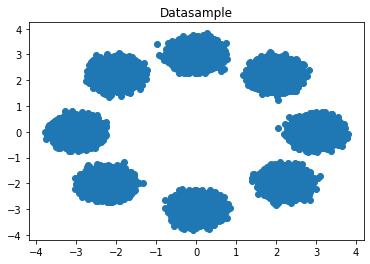

In [5]:
plt.scatter(data[:,0], data[:,1])
plt.title("Datasample")
plt.show()

In [0]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, x, transform=None):
    self.x = torch.from_numpy(x).float()
    self.transform = transform
      
  def __getitem__(self, index):
    x = self.x[index]
    
    if self.transform:
      x = self.transform(y)
    return x
  
  def __len__(self):
    return len(self.x)

In [7]:
train_ds = MyDataset(data[:260000])
len(train_ds)

260000

In [0]:
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('Linear') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [0]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # input is Z, going into a convolution
        nn.Linear(nz, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(True),

        nn.Linear(64, 32),
        nn.BatchNorm1d(32),
        nn.ReLU(True),
      
        nn.Linear(32, n_out),
        nn.Tanh()
    )

  def forward(self, input):
    out = self.main(input)
    # print("Ge out:", out.shape)
    return out

In [11]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=32, out_features=2, bias=True)
    (7): Tanh()
  )
)


In [0]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # input is Z, going into a convolution
        nn.Linear(n_out, 64),
        nn.ReLU(True),

        nn.Linear(64, 32),
        nn.ReLU(True),
      
        nn.Linear(32, 1),
        nn.Sigmoid()
    )

  def forward(self, input):
    out = self.main(input)
    # print("Ge out:", out.shape)
    return out

In [13]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [0]:
def train_d_net_with_real(data, label):
  '''
  Update D network: maximize log(D(x)) + log(1 - D(G(z)))
  '''
  ## Train with all-real batch
  netD.zero_grad()
  # Format batch
  real_cpu = data.to(device)

  # Forward pass real batch through D
  output = netD(real_cpu).view(-1)
  # print("real_out:", output.shape)
  # Calculate loss on all-real batch
  errD_real = criterion(output, label)
  # Calculate gradients for D in backward pass
  errD_real.backward()
  D_x = output.mean().item()
  return errD_real, D_x

In [0]:
def train_d_net_with_fake(label, fake, errD_real):
  '''
  Train with all-fake batch
  '''
  
  label.fill_(fake_label)
  # Classify all fake batch with D
  output = netD(fake.detach()).view(-1)
  # Calculate D's loss on the all-fake batch
  errD_fake = criterion(output, label)
  # Calculate the gradients for this batch
  errD_fake.backward()
  D_G_z1 = output.mean().item()
  # Add the gradients from the all-real and all-fake batches
  errD = errD_real + errD_fake
  # Update D
  optimizerD.step()
  return errD, D_G_z1

In [0]:
def train_g_net(data, label, fake):
  '''
  Update G network: maximize log(D(G(z)))
  '''
  netG.zero_grad()
  label.fill_(real_label)  # fake labels are real for generator cost
  # Since we just updated D, perform another forward pass of all-fake batch through D
  output = netD(fake).view(-1)
  # Calculate G's loss based on this output
  errG = criterion(output, label)
  # Calculate gradients for G
  errG.backward()
  D_G_z2 = output.mean().item()
  # Update G
  optimizerG.step()

  return errG, D_G_z2

[0/10][0/260]	Loss_D: 1.3933	Loss_G: 0.6134	D(x): 0.5418	D(G(z)): 0.5417 / 0.5415


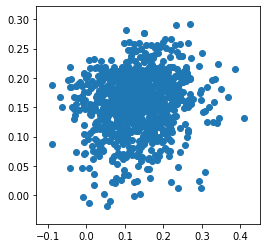

[0/10][20/260]	Loss_D: 1.3917	Loss_G: 0.6218	D(x): 0.5373	D(G(z)): 0.5372 / 0.5370
[0/10][40/260]	Loss_D: 1.3902	Loss_G: 0.6302	D(x): 0.5329	D(G(z)): 0.5327 / 0.5325
[0/10][60/260]	Loss_D: 1.3887	Loss_G: 0.6394	D(x): 0.5282	D(G(z)): 0.5279 / 0.5276
[0/10][80/260]	Loss_D: 1.3872	Loss_G: 0.6497	D(x): 0.5231	D(G(z)): 0.5225 / 0.5222
[0/10][100/260]	Loss_D: 1.3853	Loss_G: 0.6612	D(x): 0.5176	D(G(z)): 0.5165 / 0.5162


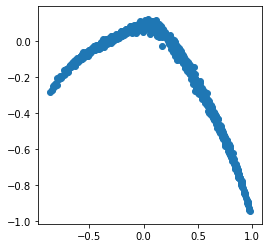

[0/10][120/260]	Loss_D: 1.3834	Loss_G: 0.6726	D(x): 0.5124	D(G(z)): 0.5107 / 0.5104
[0/10][140/260]	Loss_D: 1.3813	Loss_G: 0.6823	D(x): 0.5083	D(G(z)): 0.5057 / 0.5055
[0/10][160/260]	Loss_D: 1.3781	Loss_G: 0.6894	D(x): 0.5062	D(G(z)): 0.5020 / 0.5019
[0/10][180/260]	Loss_D: 1.3738	Loss_G: 0.6948	D(x): 0.5056	D(G(z)): 0.4993 / 0.4992
[0/10][200/260]	Loss_D: 1.3684	Loss_G: 0.6991	D(x): 0.5062	D(G(z)): 0.4972 / 0.4971


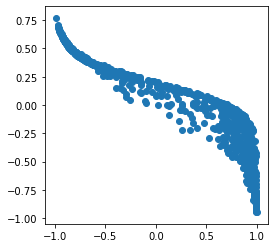

[0/10][220/260]	Loss_D: 1.3616	Loss_G: 0.7034	D(x): 0.5075	D(G(z)): 0.4950 / 0.4949
[0/10][240/260]	Loss_D: 1.3515	Loss_G: 0.7086	D(x): 0.5102	D(G(z)): 0.4925 / 0.4923
[1/10][0/260]	Loss_D: 1.3383	Loss_G: 0.7139	D(x): 0.5143	D(G(z)): 0.4899 / 0.4897
[1/10][20/260]	Loss_D: 1.3237	Loss_G: 0.7211	D(x): 0.5184	D(G(z)): 0.4865 / 0.4862
[1/10][40/260]	Loss_D: 1.3102	Loss_G: 0.7239	D(x): 0.5244	D(G(z)): 0.4853 / 0.4849


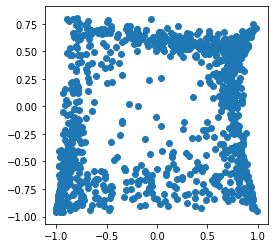

[1/10][60/260]	Loss_D: 1.2993	Loss_G: 0.7285	D(x): 0.5280	D(G(z)): 0.4831 / 0.4827
[1/10][80/260]	Loss_D: 1.2854	Loss_G: 0.7370	D(x): 0.5311	D(G(z)): 0.4790 / 0.4786
[1/10][100/260]	Loss_D: 1.2676	Loss_G: 0.7449	D(x): 0.5369	D(G(z)): 0.4752 / 0.4749
[1/10][120/260]	Loss_D: 1.2472	Loss_G: 0.7559	D(x): 0.5427	D(G(z)): 0.4701 / 0.4696
[1/10][140/260]	Loss_D: 1.2233	Loss_G: 0.7685	D(x): 0.5500	D(G(z)): 0.4643 / 0.4637


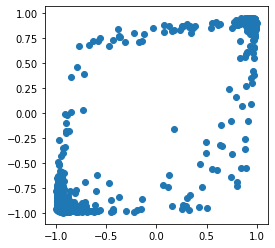

[1/10][160/260]	Loss_D: 1.2029	Loss_G: 0.7781	D(x): 0.5570	D(G(z)): 0.4601 / 0.4593
[1/10][180/260]	Loss_D: 1.1771	Loss_G: 0.7969	D(x): 0.5626	D(G(z)): 0.4514 / 0.4508
[1/10][200/260]	Loss_D: 1.1493	Loss_G: 0.8113	D(x): 0.5717	D(G(z)): 0.4447 / 0.4443
[1/10][220/260]	Loss_D: 1.1216	Loss_G: 0.8319	D(x): 0.5788	D(G(z)): 0.4358 / 0.4353
[1/10][240/260]	Loss_D: 1.0933	Loss_G: 0.8506	D(x): 0.5870	D(G(z)): 0.4277 / 0.4273


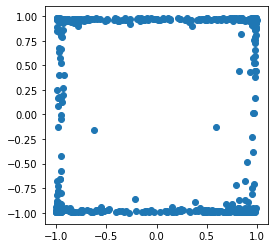

[2/10][0/260]	Loss_D: 1.0555	Loss_G: 0.8746	D(x): 0.5995	D(G(z)): 0.4178 / 0.4171
[2/10][20/260]	Loss_D: 1.0264	Loss_G: 0.8969	D(x): 0.6074	D(G(z)): 0.4085 / 0.4079
[2/10][40/260]	Loss_D: 0.9866	Loss_G: 0.9276	D(x): 0.6196	D(G(z)): 0.3964 / 0.3956
[2/10][60/260]	Loss_D: 0.9438	Loss_G: 0.9581	D(x): 0.6342	D(G(z)): 0.3844 / 0.3837
[2/10][80/260]	Loss_D: 0.9091	Loss_G: 0.9923	D(x): 0.6434	D(G(z)): 0.3716 / 0.3709


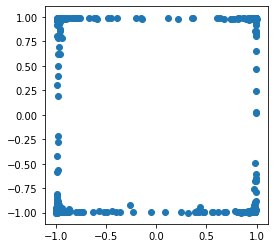

[2/10][100/260]	Loss_D: 0.8629	Loss_G: 1.0349	D(x): 0.6580	D(G(z)): 0.3561 / 0.3554
[2/10][120/260]	Loss_D: 0.8242	Loss_G: 1.0746	D(x): 0.6690	D(G(z)): 0.3418 / 0.3416
[2/10][140/260]	Loss_D: 0.7710	Loss_G: 1.1277	D(x): 0.6881	D(G(z)): 0.3249 / 0.3239
[2/10][160/260]	Loss_D: 0.7322	Loss_G: 1.1708	D(x): 0.7015	D(G(z)): 0.3116 / 0.3103
[2/10][180/260]	Loss_D: 0.6875	Loss_G: 1.2245	D(x): 0.7164	D(G(z)): 0.2947 / 0.2941


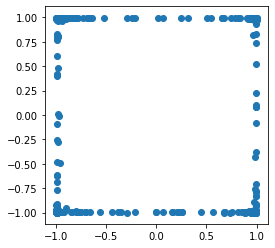

[2/10][200/260]	Loss_D: 0.6484	Loss_G: 1.2778	D(x): 0.7295	D(G(z)): 0.2795 / 0.2788
[2/10][220/260]	Loss_D: 0.6072	Loss_G: 1.3341	D(x): 0.7441	D(G(z)): 0.2641 / 0.2636
[2/10][240/260]	Loss_D: 0.5687	Loss_G: 1.3891	D(x): 0.7593	D(G(z)): 0.2502 / 0.2495
[3/10][0/260]	Loss_D: 0.5283	Loss_G: 1.4512	D(x): 0.7750	D(G(z)): 0.2354 / 0.2345
[3/10][20/260]	Loss_D: 0.5039	Loss_G: 1.5040	D(x): 0.7811	D(G(z)): 0.2228 / 0.2225


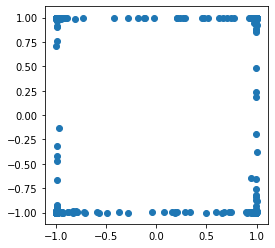

[3/10][40/260]	Loss_D: 0.4621	Loss_G: 1.5747	D(x): 0.7992	D(G(z)): 0.2080 / 0.2073
[3/10][60/260]	Loss_D: 0.4264	Loss_G: 1.6371	D(x): 0.8156	D(G(z)): 0.1958 / 0.1948
[3/10][80/260]	Loss_D: 0.3929	Loss_G: 1.7046	D(x): 0.8309	D(G(z)): 0.1835 / 0.1820
[3/10][100/260]	Loss_D: 0.3710	Loss_G: 1.7694	D(x): 0.8359	D(G(z)): 0.1708 / 0.1705
[3/10][120/260]	Loss_D: 0.3412	Loss_G: 1.8444	D(x): 0.8493	D(G(z)): 0.1591 / 0.1583


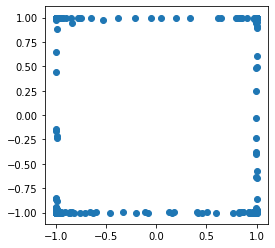

[3/10][140/260]	Loss_D: 0.3236	Loss_G: 1.9089	D(x): 0.8531	D(G(z)): 0.1482 / 0.1484
[3/10][160/260]	Loss_D: 0.2948	Loss_G: 1.9788	D(x): 0.8680	D(G(z)): 0.1389 / 0.1384
[3/10][180/260]	Loss_D: 0.2709	Loss_G: 2.0484	D(x): 0.8797	D(G(z)): 0.1298 / 0.1291
[3/10][200/260]	Loss_D: 0.2531	Loss_G: 2.1343	D(x): 0.8842	D(G(z)): 0.1186 / 0.1185
[3/10][220/260]	Loss_D: 0.2346	Loss_G: 2.2017	D(x): 0.8925	D(G(z)): 0.1110 / 0.1108


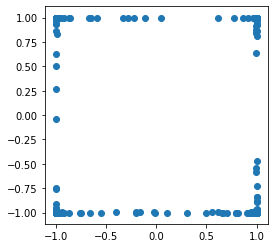

[3/10][240/260]	Loss_D: 0.2157	Loss_G: 2.2702	D(x): 0.9021	D(G(z)): 0.1037 / 0.1034
[4/10][0/260]	Loss_D: 0.1973	Loss_G: 2.3451	D(x): 0.9110	D(G(z)): 0.0965 / 0.0960
[4/10][20/260]	Loss_D: 0.1849	Loss_G: 2.4039	D(x): 0.9167	D(G(z)): 0.0911 / 0.0905
[4/10][40/260]	Loss_D: 0.1756	Loss_G: 2.4802	D(x): 0.9182	D(G(z)): 0.0840 / 0.0839
[4/10][60/260]	Loss_D: 0.1619	Loss_G: 2.5336	D(x): 0.9264	D(G(z)): 0.0798 / 0.0795


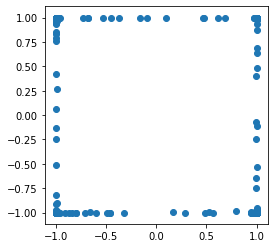

[4/10][80/260]	Loss_D: 0.1533	Loss_G: 2.6057	D(x): 0.9286	D(G(z)): 0.0740 / 0.0740
[4/10][100/260]	Loss_D: 0.1392	Loss_G: 2.6816	D(x): 0.9363	D(G(z)): 0.0690 / 0.0686
[4/10][120/260]	Loss_D: 0.1328	Loss_G: 2.7419	D(x): 0.9380	D(G(z)): 0.0649 / 0.0647
[4/10][140/260]	Loss_D: 0.1232	Loss_G: 2.7947	D(x): 0.9437	D(G(z)): 0.0617 / 0.0613
[4/10][160/260]	Loss_D: 0.1162	Loss_G: 2.8633	D(x): 0.9459	D(G(z)): 0.0573 / 0.0572


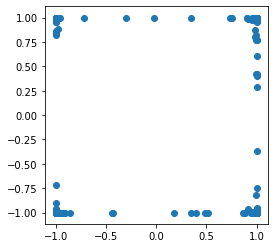

[4/10][180/260]	Loss_D: 0.1077	Loss_G: 2.9147	D(x): 0.9513	D(G(z)): 0.0548 / 0.0544
[4/10][200/260]	Loss_D: 0.1023	Loss_G: 2.9789	D(x): 0.9525	D(G(z)): 0.0512 / 0.0510
[4/10][220/260]	Loss_D: 0.0947	Loss_G: 3.0445	D(x): 0.9567	D(G(z)): 0.0480 / 0.0478
[4/10][240/260]	Loss_D: 0.0884	Loss_G: 3.1070	D(x): 0.9599	D(G(z)): 0.0452 / 0.0449
[5/10][0/260]	Loss_D: 0.0872	Loss_G: 3.1506	D(x): 0.9586	D(G(z)): 0.0429 / 0.0429


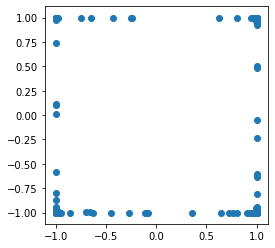

[5/10][20/260]	Loss_D: 0.0817	Loss_G: 3.2048	D(x): 0.9619	D(G(z)): 0.0409 / 0.0407
[5/10][40/260]	Loss_D: 0.0758	Loss_G: 3.2644	D(x): 0.9652	D(G(z)): 0.0386 / 0.0384
[5/10][60/260]	Loss_D: 0.0731	Loss_G: 3.3026	D(x): 0.9661	D(G(z)): 0.0371 / 0.0370
[5/10][80/260]	Loss_D: 0.0693	Loss_G: 3.3544	D(x): 0.9678	D(G(z)): 0.0351 / 0.0351
[5/10][100/260]	Loss_D: 0.0645	Loss_G: 3.4096	D(x): 0.9704	D(G(z)): 0.0333 / 0.0332


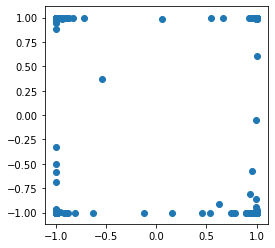

[5/10][120/260]	Loss_D: 0.0605	Loss_G: 3.4638	D(x): 0.9727	D(G(z)): 0.0316 / 0.0314
[5/10][140/260]	Loss_D: 0.0604	Loss_G: 3.5255	D(x): 0.9707	D(G(z)): 0.0295 / 0.0296
[5/10][160/260]	Loss_D: 0.0569	Loss_G: 3.5597	D(x): 0.9731	D(G(z)): 0.0286 / 0.0286
[5/10][180/260]	Loss_D: 0.0529	Loss_G: 3.6126	D(x): 0.9756	D(G(z)): 0.0271 / 0.0271
[5/10][200/260]	Loss_D: 0.0503	Loss_G: 3.6675	D(x): 0.9767	D(G(z)): 0.0258 / 0.0257


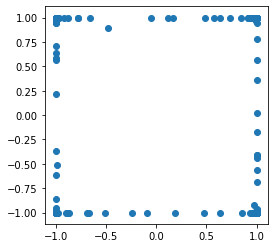

[5/10][220/260]	Loss_D: 0.0475	Loss_G: 3.7317	D(x): 0.9777	D(G(z)): 0.0242 / 0.0241
[5/10][240/260]	Loss_D: 0.0493	Loss_G: 3.7474	D(x): 0.9757	D(G(z)): 0.0236 / 0.0237
[6/10][0/260]	Loss_D: 0.0439	Loss_G: 3.8056	D(x): 0.9794	D(G(z)): 0.0224 / 0.0224
[6/10][20/260]	Loss_D: 0.0412	Loss_G: 3.8549	D(x): 0.9809	D(G(z)): 0.0214 / 0.0213
[6/10][40/260]	Loss_D: 0.0412	Loss_G: 3.8921	D(x): 0.9802	D(G(z)): 0.0205 / 0.0205


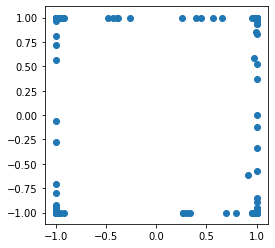

[6/10][60/260]	Loss_D: 0.0384	Loss_G: 3.9394	D(x): 0.9823	D(G(z)): 0.0196 / 0.0196
[6/10][80/260]	Loss_D: 0.0355	Loss_G: 3.9785	D(x): 0.9840	D(G(z)): 0.0189 / 0.0188
[6/10][100/260]	Loss_D: 0.0347	Loss_G: 4.0297	D(x): 0.9839	D(G(z)): 0.0179 / 0.0179
[6/10][120/260]	Loss_D: 0.0353	Loss_G: 4.0583	D(x): 0.9827	D(G(z)): 0.0173 / 0.0174
[6/10][140/260]	Loss_D: 0.0313	Loss_G: 4.1130	D(x): 0.9858	D(G(z)): 0.0165 / 0.0165


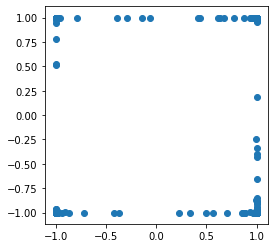

[6/10][160/260]	Loss_D: 0.0320	Loss_G: 4.1467	D(x): 0.9844	D(G(z)): 0.0159 / 0.0159
[6/10][180/260]	Loss_D: 0.0281	Loss_G: 4.1982	D(x): 0.9874	D(G(z)): 0.0152 / 0.0151
[6/10][200/260]	Loss_D: 0.0280	Loss_G: 4.2217	D(x): 0.9873	D(G(z)): 0.0148 / 0.0147
[6/10][220/260]	Loss_D: 0.0262	Loss_G: 4.2652	D(x): 0.9884	D(G(z)): 0.0142 / 0.0141
[6/10][240/260]	Loss_D: 0.0264	Loss_G: 4.2946	D(x): 0.9878	D(G(z)): 0.0138 / 0.0137


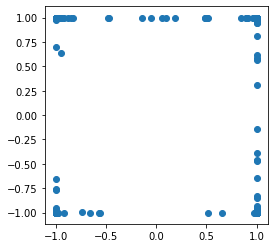

[7/10][0/260]	Loss_D: 0.0253	Loss_G: 4.3384	D(x): 0.9883	D(G(z)): 0.0132 / 0.0131
[7/10][20/260]	Loss_D: 0.0252	Loss_G: 4.3753	D(x): 0.9880	D(G(z)): 0.0127 / 0.0127
[7/10][40/260]	Loss_D: 0.0244	Loss_G: 4.4069	D(x): 0.9882	D(G(z)): 0.0123 / 0.0123
[7/10][60/260]	Loss_D: 0.0239	Loss_G: 4.4377	D(x): 0.9884	D(G(z)): 0.0119 / 0.0119
[7/10][80/260]	Loss_D: 0.0216	Loss_G: 4.4700	D(x): 0.9903	D(G(z)): 0.0116 / 0.0115


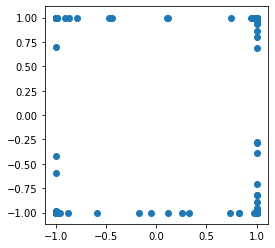

[7/10][100/260]	Loss_D: 0.0223	Loss_G: 4.5045	D(x): 0.9892	D(G(z)): 0.0111 / 0.0111
[7/10][120/260]	Loss_D: 0.0216	Loss_G: 4.5456	D(x): 0.9895	D(G(z)): 0.0107 / 0.0107
[7/10][140/260]	Loss_D: 0.0200	Loss_G: 4.5934	D(x): 0.9905	D(G(z)): 0.0102 / 0.0102
[7/10][160/260]	Loss_D: 0.0189	Loss_G: 4.6066	D(x): 0.9915	D(G(z)): 0.0101 / 0.0101
[7/10][180/260]	Loss_D: 0.0189	Loss_G: 4.6379	D(x): 0.9911	D(G(z)): 0.0097 / 0.0097


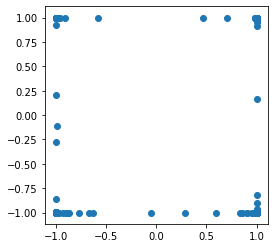

[7/10][200/260]	Loss_D: 0.0178	Loss_G: 4.6659	D(x): 0.9919	D(G(z)): 0.0095 / 0.0094
[7/10][220/260]	Loss_D: 0.0171	Loss_G: 4.7005	D(x): 0.9923	D(G(z)): 0.0092 / 0.0092
[7/10][240/260]	Loss_D: 0.0168	Loss_G: 4.7393	D(x): 0.9922	D(G(z)): 0.0088 / 0.0088
[8/10][0/260]	Loss_D: 0.0158	Loss_G: 4.7669	D(x): 0.9930	D(G(z)): 0.0086 / 0.0086
[8/10][20/260]	Loss_D: 0.0167	Loss_G: 4.7998	D(x): 0.9918	D(G(z)): 0.0083 / 0.0083


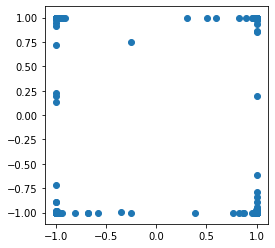

[8/10][40/260]	Loss_D: 0.0169	Loss_G: 4.8195	D(x): 0.9916	D(G(z)): 0.0081 / 0.0081
[8/10][60/260]	Loss_D: 0.0156	Loss_G: 4.8836	D(x): 0.9923	D(G(z)): 0.0076 / 0.0076
[8/10][80/260]	Loss_D: 0.0146	Loss_G: 4.9079	D(x): 0.9931	D(G(z)): 0.0075 / 0.0075
[8/10][100/260]	Loss_D: 0.0135	Loss_G: 4.9166	D(x): 0.9940	D(G(z)): 0.0074 / 0.0074
[8/10][120/260]	Loss_D: 0.0141	Loss_G: 4.9394	D(x): 0.9933	D(G(z)): 0.0072 / 0.0072


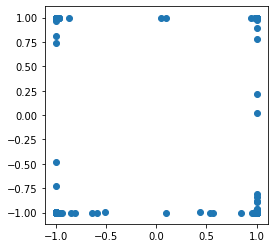

[8/10][140/260]	Loss_D: 0.0138	Loss_G: 4.9844	D(x): 0.9933	D(G(z)): 0.0069 / 0.0069
[8/10][160/260]	Loss_D: 0.0126	Loss_G: 5.0046	D(x): 0.9943	D(G(z)): 0.0068 / 0.0067
[8/10][180/260]	Loss_D: 0.0137	Loss_G: 5.0071	D(x): 0.9932	D(G(z)): 0.0067 / 0.0067
[8/10][200/260]	Loss_D: 0.0122	Loss_G: 5.0617	D(x): 0.9943	D(G(z)): 0.0064 / 0.0064
[8/10][220/260]	Loss_D: 0.0127	Loss_G: 5.0995	D(x): 0.9936	D(G(z)): 0.0061 / 0.0061


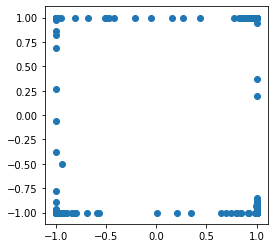

[8/10][240/260]	Loss_D: 0.0124	Loss_G: 5.1063	D(x): 0.9939	D(G(z)): 0.0061 / 0.0061
[9/10][0/260]	Loss_D: 0.0112	Loss_G: 5.1402	D(x): 0.9948	D(G(z)): 0.0059 / 0.0059
[9/10][20/260]	Loss_D: 0.0104	Loss_G: 5.1546	D(x): 0.9955	D(G(z)): 0.0058 / 0.0058
[9/10][40/260]	Loss_D: 0.0102	Loss_G: 5.1909	D(x): 0.9955	D(G(z)): 0.0056 / 0.0056
[9/10][60/260]	Loss_D: 0.0101	Loss_G: 5.2271	D(x): 0.9954	D(G(z)): 0.0054 / 0.0054


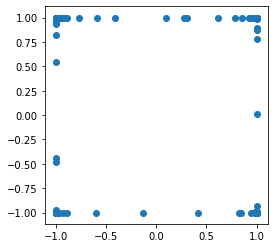

[9/10][80/260]	Loss_D: 0.0103	Loss_G: 5.2621	D(x): 0.9950	D(G(z)): 0.0052 / 0.0052
[9/10][100/260]	Loss_D: 0.0098	Loss_G: 5.2751	D(x): 0.9954	D(G(z)): 0.0052 / 0.0052
[9/10][120/260]	Loss_D: 0.0095	Loss_G: 5.3000	D(x): 0.9956	D(G(z)): 0.0050 / 0.0050
[9/10][140/260]	Loss_D: 0.0096	Loss_G: 5.3258	D(x): 0.9954	D(G(z)): 0.0049 / 0.0049
[9/10][160/260]	Loss_D: 0.0100	Loss_G: 5.3311	D(x): 0.9950	D(G(z)): 0.0049 / 0.0049


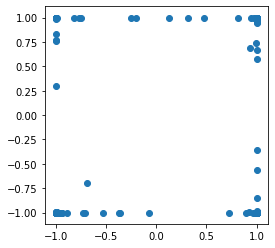

[9/10][180/260]	Loss_D: 0.0084	Loss_G: 5.3938	D(x): 0.9963	D(G(z)): 0.0046 / 0.0046
[9/10][200/260]	Loss_D: 0.0088	Loss_G: 5.3874	D(x): 0.9959	D(G(z)): 0.0046 / 0.0046
[9/10][220/260]	Loss_D: 0.0086	Loss_G: 5.4158	D(x): 0.9959	D(G(z)): 0.0045 / 0.0045
[9/10][240/260]	Loss_D: 0.0085	Loss_G: 5.4319	D(x): 0.9960	D(G(z)): 0.0044 / 0.0044


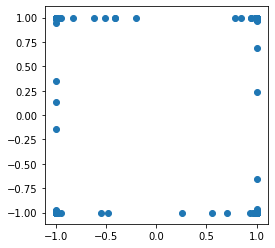

In [18]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(EPOCHS):
  netG.train()
  netD.train()
  for i, x in enumerate(trainloader, 0):
    x = x.to(device).float()
    
    # real label
    b_size = x.size(0)
    label = torch.full((b_size,), real_label, device=device)

    errD_real, D_x = train_d_net_with_real(x, label)

    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, device=device)
    # Generate fake image batch with G
    fake = netG(noise)

    errD, D_G_z1 = train_d_net_with_fake(label, fake, errD_real)

    errG, D_G_z2 = train_g_net(x, label, fake)



    # print stats
    if i % 20 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(trainloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # Check how the generator is doing by saving G's output on fixed_noise
    if (iters % 100 == 0) or ((epoch == EPOCHS-1) and (i == len(trainloader)-1)):
      with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
      fig = plt.figure(figsize=(4,4))
      plt.scatter(fake[:,0], fake[:,1])
      plt.show()
      img_list.append(fake)

    iters += 1

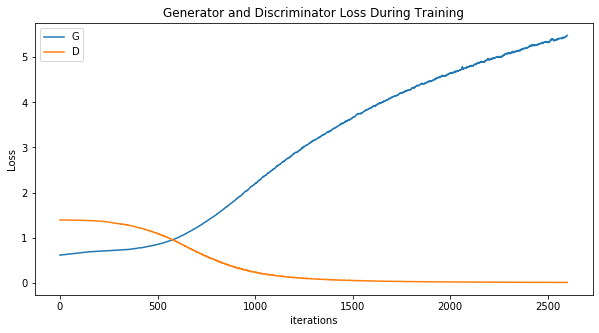

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

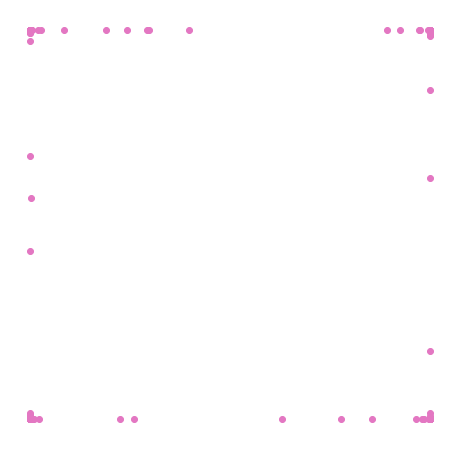

In [22]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.scatter(i[:,0], i[:,1])] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())